In [1]:
%who

Interactive namespace is empty.


In [2]:
import os
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
import pymc3 as pm
import re
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, time
import pingouin as pg

from collections import Counter
import glob

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/yurir/opt/anaconda3/envs/kernel2/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

In [ ]:
'''
A. Chronic Kidney Disease (CKD) incidence and progression risk factors: rapid literature review

Demographic:
    1. Gender [males - faster progression]
    Many registries including the Japanese Society for Dialysis Therapy have demonstrated that 
    ESRD is more frequent among men. In one study, a total of 107,192 subjects over 18 years of age 
    (51,122 men and 56,070 women) from Okinawa, Japan participated in a 10-year follow-up where odds ratio 
    for ESRD was 1.41 among male participants. In contrast, the CREDIT study demonstrated that 
    CKD is higher in women than in men (18.4 vs. 12.8%) in Turkey.

    2. Race/ethnicity [non-white - faster progression]
    Several studies performed in the United States have confirmed an increased risk for the development of 
    ESRD in African Americans compared with Caucasians. n a recent study, it was found that the lifetime risk 
    of ESRD was 7.8% for 20 year old black women, 7.3% for black men, 1.8% for white women, and 2.5% for white men.

    3. Age
    In the CREDIT study the odds ratios of CKD ranged from 1.45 to 2.18 for every 10-year increase in age 
    among subjects older than 30 years of age in Turkey.
    The odd ratio was more than 2-fold higher among participants aged 50–69 an older.

Health & physiology biomarkers
    4. T2D [faster progression]
    Diabetes mellitus (DM) is the leading cause of CKD. 37% of CKD in Turkey.
    Diabetes was associated with more than 4-fold higher risk of CKD [adjusted odd ratio 4.45 (2.18, 9.07), P < 0.001]. 
    A fasting blood sugar level less than 5.6 mmol/L is normal. 
    A fasting blood sugar level from 5.6 to 6.9 mmol/L is considered prediabetes. 
    7 mmol/L or higher - you have diabetes.

    5. Hypertention [faster progression]
    Hypertension has long been a defined risk factor for CKD, and accounts for 27% 
    of all ESRD patients in the United States and 28% of hemodialysis patients in Turkey.
    5.9% of those with hypertention had a serum creatinine of 1.5 mg/dl or greater. 
    Hypertension was associated with more than 3-fold higer risk of CKD [adjusted odd ratio (AOR 3.46 (95%CI 1.92, 6.24), P < 0.001] 
    Hypertention criteria: 
        SBP = 135 or DBP = 85 (latest guidlines for home daytime measurements)
        SBP is more important

    6. Creatinine
    A normal result is 0.7 to 1.3 mg/dL for men and 0.6 to 1.1 mg/dL for women.
    As kidney disease gets worse, the level of creatinine goes up.
    2.3% of those with serial serum creatinine measurements above 1.5 mg/dl experienced 
    clinically significant loss of renal function over 5 years.
    
    7. Anemia / hemoglobin (HGB) [faster progression]
    Anemia is a condition in which your blood has a lower-than-normal amount of hemoglobin.
    Anemia if (US ref): 
        hemoglobin < 13.5 g/dL in a man 
        hemoglobin < 12 g/dL in a woman
    Anemia is less common in early kidney disease, and it often gets worse as 
    kidney disease progresses and more kidney function is lost. 

    ? 8. 2.1. Metabolic disorders (diabetes, hypertention, hyperlipidemia) increase risk of CKD progression.
    High LDL values (>= 116/130/140 mg/dl) - marker of hyperlipidemia, yet lowering LDL cholesterol by 1 mmol/L did not slow 
    kidney disease progression within 5 years in a wide range of patients with CKD.
    2. ACR prediction:
    estimated ACR = HGB + ?LDL

B. CKD progression
    1. CKD stages are determined by Glomerular Filtration Rate (GFR) vales.
    The common criteria:
    Category	GFR 	Terms
    G1	        ≥90	    Normal or high
    G2	        60-89	Mildly decreased*
    G3a	        45-59	Mildly to moderately decreased
    G3b	        30-44	Moderately to severely decreased
    G4	        15-29	Severely decreased
    G5	        <15	    Kidney failure

    There is established standard GFR calculator (estimator) based on input from otger lab tests and demograhip data:
    eGFR = Age + Gender + Creatinine + [optional]Cystatin C
    ___________
    eGFR equation:
    eGFR = 142 * min(standardized Scr/K, 1)α * max(standardized Scr/K, 1)-1.200 * 0.9938 Age * 1.012 [if female]

    Abbreviations / Units:
    eGFR (estimated glomerular filtration rate) = mL/min/ 1.73 m2
    Scr (serum creatinine) = mg/dL
    K = 0.7 (females) or 0.9 (males)
    α = -0.241 (females) or -0.302 (males)
    min = indicates the minimum of Scr/K or 1
    max = indicates the maximum of Scr/K or 1
    __________

    However, to estimate pregression to the next CKD stage (according to established methods) we also need 
    urine albumin to creatinine ratio (ACR). Hence, to predict progression to the next stage we need to obtain 
    ACR values predicted from other biomarkers. 

    StageProgression = eGFR + estimated ACR
    

2.2. There is a strong correlation (R = 0.82) between glycated hemoglobin and microalbuminuria, 
1% increase in HbA1c corresponding approximately to an increase of 39.7 mg/I of microalbuminuria.
HbA1c:
For men: 13.2 to 16.6 g/dl [alt in UK: 13-18]
For women: 11.6 to 15 g/dl [alt in UK: 11.5 - 16.5]


In [ ]:
'''
Task formulation: evidence-based theoretical CKD progression model

To estimate mean change in eGFR at future timepoints: next 1 (=365 days), 2, 5 and 10 years.
We can model eGFR with avaialble data at each time point and extrapolate linear trend supported with additioanl evidence.

'''

In [ ]:
'''
Analysis and prediction modeling design

0. Exploratory analysis (univariate and bi-variate):
    0.1. Outcome distribution (prevalence of CKD stage progression)
    0.2. Measurement timepoints distribution
    0.3. Test normality of distributions
    0.4. Test relationship between variables (boxplots, t-test / Kruskal–Wallis test)

1. Logistic regression is used to fit model and estimate goodness-of-fit (pseudo R2 and confusion matrix)
Repeated measures (time-series domain) is transformed into scalar estimates obtained via 
fitting mixed-effect (milti-level) linear models and/or  subject-sample-only linear model
    1.1. Only eGFR is fitted and estimated: intercept, last value and slope are extracted and used as features
        1.1.1. Other biomarkers are averaged (+std) and last measurement taken as features
        1.1.2. Other biomarkers are averaged and last measurement taken and then transformed into binary categorical (+std)
    1.2. All repeated measures data (bioamrkers) are estimated: intercepts, last values and slopes are extracted 
        1.2.1. Used alone as predictirs
        ? 1.2.2. Used with categorical dummy 

2. Mixed-effect (repated measures) logistic regression is used to fit the model
    2.1. Repeated measures (time-series domain) -> aggregated into regular assessment intervals
    
'''

In [ ]:
'''
Exploratory analysis
'''

In [3]:
# load data and read

#path = '/Users/yurir/OneDrive - Neuroglee Therapeutics/Py_MC/dataScienceTask/'
#files = os.listdir(path)

files = [i for i in glob.glob('T_*'.format('csv'))]
files

['T_SBP.csv',
 'T_stage.csv',
 'T_demo.csv',
 'T_creatinine.csv',
 'T_HGB.csv',
 'T_ldl.csv',
 'T_meds.csv',
 'T_glucose.csv',
 'T_DBP.csv']

In [4]:
# read repeatd measures data (biomarkers)
biomarkers_df = pd.DataFrame()
files_nonrep = []
for i in files:
    df = pd.read_csv(i)
    filename = i.split(".")[0].split("_")[1]
    if df.shape[1] == 3: # select only biomarker data
        df[['id', 'time']] = df[['id', 'time']].applymap(str) # int variables to str
        df['id_time'] = 'S' + df.id + '_' + df.time # create new unique ID index for subject-time pairs
        df = df.drop(columns=['id', 'time'])
        df.rename(columns = {"value": filename}, inplace = True) # rename column biomarker variable
        df = df.set_index(['id_time'])
        biomarkers_df = pd.concat([biomarkers_df, df], axis = 1) # merge data
    else:
        files_nonrep.append(i)
biomarkers_df = biomarkers_df.sort_index()
biomarkers_df['id_time']=biomarkers_df.index
biomarkers_df.id_time.str.split('_', expand=True)
biomarkers_df = pd.concat([biomarkers_df, biomarkers_df.id_time.str.split('_', expand=True)], axis = 1)
biomarkers_df.rename(columns = {0: 'id', 1: 'time_day'}, inplace = True)
biomarkers_df.time_day = biomarkers_df.time_day.apply(float)
biomarkers_df = biomarkers_df.sort_values(['id','time_day'])
biomarkers_df = biomarkers_df[['id_time', 'id', 'time_day', 'creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']]
print(biomarkers_df.shape)
print("N =", len(biomarkers_df.id.unique()))

(4761, 9)
N = 300


In [5]:
# biomarkers descriptive statistics 
biomarkers_df.describe(include = 'all')

,id_time,id,time_day,creatinine,glucose,ldl,HGB,SBP,DBP
count,4761,4761,4761.00000,1439.000000,1556.000000,1261.000000,2025.000000,1809.000000,1821.000000
unique,4761,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,S0_0,S110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,462.41924,1.328999,6.694833,87.558795,13.825185,134.155368,79.518583
std,NaN,NaN,334.49964,0.357971,1.599058,28.156104,1.644946,14.765817,10.178676
min,NaN,NaN,0.00000,0.240000,2.890000,26.100000,8.820000,91.990000,44.950000
25%,NaN,NaN,196.00000,1.080000,5.620000,67.290000,12.670000,124.630000,72.830000
50%,NaN,NaN,414.00000,1.290000,6.360000,83.960000,13.920000,133.440000,79.050000
75%,NaN,NaN,640.00000,1.530000,7.440000,105.140000,14.980000,143.160000,86.170000


In [6]:
# read constant variablr data (demograhpics and outcome)
subj_df = pd.DataFrame()
for i in files_nonrep:
    df = pd.read_csv(i)
    if df.shape[0] == 300: # select only constant variable data (== N)
        df.id = "S" + df.id.apply(str)
        df = df.set_index(['id'])
        subj_df = pd.concat([subj_df, df], axis = 1) # merge data
subj_df['id'] = subj_df.index
print(subj_df.describe(include = 'all'))

       Stage_Progress   race  gender         age   id
count             300    300     300  300.000000  300
unique              2      5       2         NaN  300
top             False  White  Female         NaN   S0
freq              200    226     176         NaN    1
mean              NaN    NaN     NaN   70.383333  NaN
std               NaN    NaN     NaN    9.247058  NaN
min               NaN    NaN     NaN   46.000000  NaN
25%               NaN    NaN     NaN   64.000000  NaN
50%               NaN    NaN     NaN   71.000000  NaN
75%               NaN    NaN     NaN   78.000000  NaN
max               NaN    NaN     NaN   86.000000  NaN


In [7]:
# read relational data (medications)

meds_df = pd.read_csv('T_meds.csv')
meds_df.id = "S" + meds_df.id.apply(str)
meds_df = meds_df.set_index(['id'])
meds_df['id'] = meds_df.index
meds_df['duration_dose'] = (meds_df.end_day - meds_df.start_day) * meds_df.daily_dosage
print(meds_df.describe(include = 'all'))

             drug  daily_dosage    start_day      end_day    id  duration_dose
count        2181   2181.000000  2181.000000  2181.000000  2181    2181.000000
unique         21           NaN          NaN          NaN   272            NaN
top     metformin           NaN          NaN          NaN   S50            NaN
freq          482           NaN          NaN          NaN    31            NaN
mean          NaN    276.653141   291.254470   370.996332   NaN   20594.989913
std           NaN    478.411077   191.087155   190.575803   NaN   43134.968181
min           NaN      2.000000   -78.000000    -4.000000   NaN       6.000000
25%           NaN     20.000000   126.000000   208.000000   NaN    1500.000000
50%           NaN     50.000000   290.000000   377.000000   NaN    3600.000000
75%           NaN    320.000000   448.000000   534.000000   NaN   15000.000000
max           NaN   2550.000000   691.000000   698.000000   NaN  540000.000000


In [8]:
pd.set_option('display.max_rows', 10)

meds_summary = pd.DataFrame(columns = ['id'] + list(meds_df.drug.unique()))
meds_summary = meds_summary.set_index('id')
for i in meds_df['id'].unique():
    subj = meds_df[meds_df['id'] == i]
    med_summary = subj.groupby('drug').duration_dose.sum()
    med_summary.index.name = None
    med_summary = med_summary.to_frame().transpose()
    med_summary['id'] = i
    med_summary = med_summary.set_index('id')
    meds_summary = pd.concat([meds_summary, med_summary], axis = 0)
meds_summary = meds_summary.applymap(lambda x: 0 if np.isnan(x) else x)

In [9]:
meds_summary.describe(include = 'all')

,atorvastatin,losartan,metformin,rosuvastatin,pravastatin,carvedilol,valsartan,metoprolol,simvastatin,bisoprolol,...,lovastatin,olmesartan,irbesartan,canagliflozin,dapagliflozin,telmisartan,labetalol,nebivolol,pitavastatin,propranolol
count,272.000000,272.000000,2.720000e+02,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,...,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000,272.000000
mean,3424.705882,5768.198529,1.332011e+05,562.683824,1198.308824,388.786765,9065.294118,4323.437500,2379.227941,30.882353,...,399.448529,161.029412,678.308824,341.911765,7.720588,101.470588,727.941176,18.198529,2.860294,46.323529
std,7220.737146,13074.109287,2.221594e+05,2031.761583,4328.260698,2318.730278,33809.985488,13068.270383,5446.257098,280.323931,...,2008.563234,1115.914583,5348.414954,3531.201047,110.580267,871.863195,12005.513439,219.630831,46.809447,568.601325
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3600.000000,2250.000000,1.800000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1275.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,43200.000000,72000.000000,1.170000e+06,18000.000000,28800.000000,27750.000000,249600.000000,126000.000000,34800.000000,3600.000000,...,18000.000000,10800.000000,72000.000000,45000.000000,1800.000000,9600.000000,198000.000000,3150.000000,772.000000,8400.000000


In [10]:
# merge demographic and medications data
subj_meds_df = pd.concat([subj_df, meds_summary], axis = 1)
subj_meds_df = subj_meds_df.fillna(0)

In [ ]:
'''
More info in distribution of categorical variables
'''

False    200
True     100
Name: Stage_Progress, dtype: int64
White       0.753333
Unknown     0.086667
Black       0.080000
Asian       0.056667
Hispanic    0.023333
Name: race, dtype: float64
Female    0.586667
Male      0.413333
Name: gender, dtype: float64


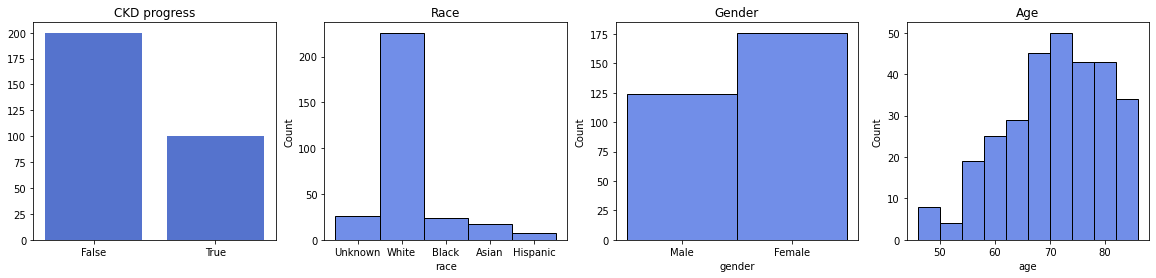

In [11]:
plt.rcParams['figure.figsize'] = [20, 4]
fig, axs = plt.subplots(1,4)

sns.barplot(ax=axs[0], x = subj_df.Stage_Progress.value_counts().index, 
            y = subj_df.Stage_Progress.value_counts().values, color = 'royalblue').set(title = "CKD progress")
sns.histplot(ax=axs[1], data=subj_df.race,color = 'royalblue').set(title = "Race")
sns.histplot(ax=axs[2], data=subj_df.gender,color = 'royalblue').set(title = "Gender")
sns.histplot(ax=axs[3], data=subj_df.age,color = 'royalblue').set(title = "Age")

print(subj_df.Stage_Progress.value_counts())
print(subj_df.race.value_counts()/300)
print(subj_df.gender.value_counts()/300)

False    200
True     100
Name: Stage_Progress, dtype: int64
White       0.753333
Unknown     0.086667
Black       0.080000
Asian       0.056667
Hispanic    0.023333
Name: race, dtype: float64
Female    0.586667
Male      0.413333
Name: gender, dtype: float64
count    300.000000
mean      70.383333
std        9.247058
min       46.000000
25%       64.000000
50%       71.000000
75%       78.000000
max       86.000000
Name: age, dtype: float64


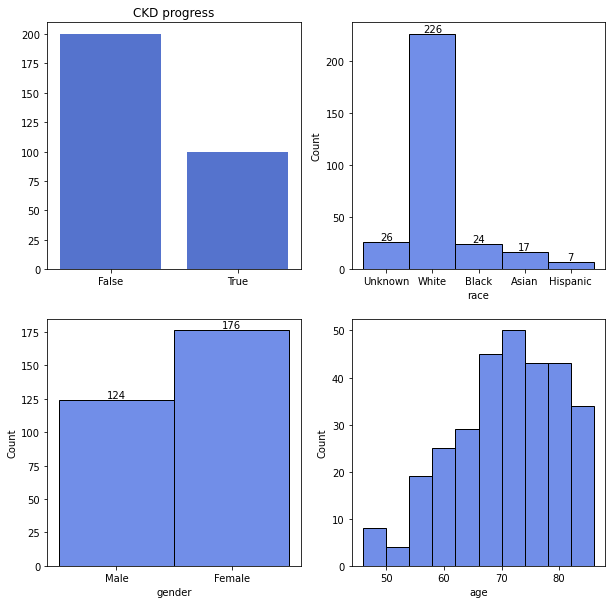

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]
fig, axs = plt.subplots(2,2)

sns.barplot(ax=axs[0,0], x = subj_df.Stage_Progress.value_counts().index, 
            y = subj_df.Stage_Progress.value_counts().values, color = 'royalblue').set(title = "CKD progress")
sns.histplot(ax=axs[0,1], data=subj_df.race,color = 'royalblue').bar_label(axs[0,1].containers[0])
sns.histplot(ax=axs[1,0], data=subj_df.gender,color = 'royalblue').bar_label(axs[1,0].containers[0])
sns.histplot(ax=axs[1,1], data=subj_df.age,color = 'royalblue')

print(subj_df.Stage_Progress.value_counts())
print(subj_df.race.value_counts()/300)
print(subj_df.gender.value_counts()/300)
print(subj_df.age.describe())

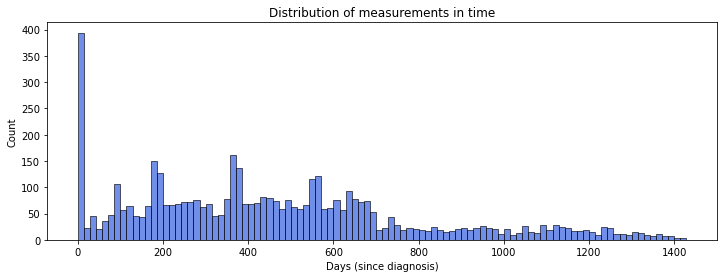

In [13]:
plt.rcParams['figure.figsize'] = [12, 4]
plot5 = sns.histplot(data=biomarkers_df.time_day,bins=100,color = "royalblue").set(title = "Distribution of measurements in time",
                                                             xlabel = "Days (since diagnosis)")

[Text(0.5, 1.0, 'Distribution of measurements among subjects'),
 Text(0.5, 0, 'N of measurements'),
 Text(0, 0.5, 'Count / subjects')]

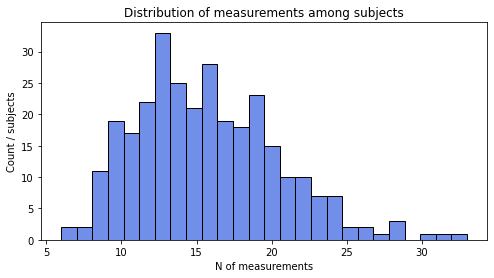

In [15]:
plt.rcParams['figure.figsize'] = [8, 4]
sns.histplot(biomarkers_df.id.value_counts(), 
             bins = len(biomarkers_df.id.value_counts().value_counts()), 
             color = "royalblue").set(title = "Distribution of measurements among subjects",
                                               xlabel = "N of measurements",
                                               ylabel = "Count / subjects")

In [14]:
# filter out 'DBP' and 'SBP' biomarkers which are often taken outside of appointments and 'HGB' which is taken beyond 2 year timeframe

biomarkers_df2 = biomarkers_df.drop(columns=['DBP','SBP', 'HGB']).dropna(axis=0, how='all', subset = ['creatinine', 'ldl', 'glucose'])

[Text(0.5, 1.0, 'Distribution of measurements among subjects (without BP and HGB measures)'),
 Text(0.5, 0, 'N of measurements'),
 Text(0, 0.5, 'Count / subjects')]

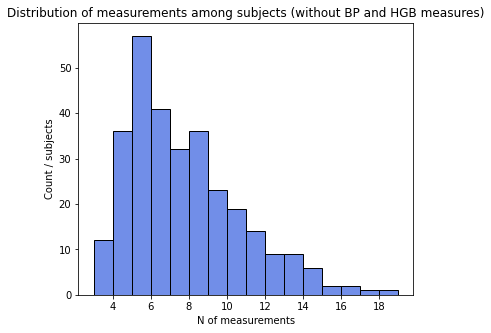

In [15]:
plt.rcParams['figure.figsize'] = [6, 5]
sns.histplot(biomarkers_df2.id.value_counts(), 
             bins = len(biomarkers_df2.id.value_counts().value_counts()), 
             color = 'royalblue').set(title = "Distribution of measurements among subjects (without BP and HGB measures)",
                                               xlabel = "N of measurements",
                                               ylabel = "Count / subjects")

<AxesSubplot:title={'center':'Distribution of measurements among subjects'}, xlabel='N of measurements', ylabel='Count / subjects'>

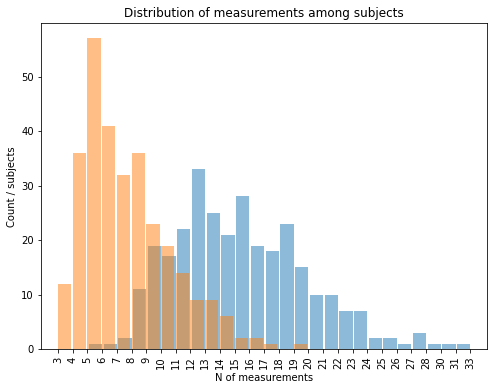

In [16]:
plt.rcParams['figure.figsize'] = [8, 6]
plot_df1 = pd.DataFrame()
plot_df1['px1'] = biomarkers_df.id.value_counts().value_counts().index 
plot_df1['py1'] = biomarkers_df.id.value_counts().value_counts().values
plot_df1 = plot_df1.sort_values('px1')
plot_df1 = plot_df1.set_index('px1')

plot_df2 = pd.DataFrame()
plot_df2['px2'] = biomarkers_df2.id.value_counts().value_counts().index 
plot_df2['py2'] = biomarkers_df2.id.value_counts().value_counts().values
plot_df2 = plot_df2.sort_values('px2')
plot_df2 = plot_df2.set_index('px2')

plot_df = pd.concat([plot_df1, plot_df2], axis = 1)
plot_df.plot.bar(width = 1.8,alpha=0.5,
                 legend=None,
                 title = "Distribution of measurements among subjects",
                 xlabel = 'N of measurements', ylabel = 'Count / subjects')

In [ ]:
'''
Two most frequent number of measurements are 5 and 6, that corresponds to observed peaks in time-distribution.
=> all measurements among subjects can be grouped into time intervals corresponding to common appointment schedule:

It's known that based on the CKD stage the max number of recomended visits are 4 per year (each 3 months ), hence
grouping variable can be created +- N days (~45) for each 90 days after diagnosis/1st visit.
'''

In [17]:
# group repeated biomarker measures into 3-months intervals
# baseline, then 1-45 days, and then 3-month windows with mid points at 3, 6, 12 months, etc

ints = [-1] + [0] + list(range(45, int(max(biomarkers_df.time_day)), 90)) + [int(max(biomarkers_df.time_day))]
ints_names = [1] + list(range(3, (len(ints)-2)*3, 3))
ints_names = ['baseline_0'] + ['followup_' + str(i) for i in ints_names]
Ints = pd.cut(biomarkers_df.time_day, ints, labels = ints_names)
biomarkers_df['assessment'] = Ints
biomarkers_df

,id_time,id,time_day,creatinine,glucose,ldl,HGB,SBP,DBP,assessment
id_time,,,,,,,,,,
S0_0,S0_0,S0,0.0,1.29,6.24,161.49,13.51,134.11,95.32,baseline_0
S0_98,S0_98,S0,98.0,NaN,NaN,NaN,NaN,133.75,83.98,followup_3
S0_107,S0_107,S0,107.0,1.15,7.20,111.39,13.39,NaN,NaN,followup_3
S0_279,S0_279,S0,279.0,NaN,NaN,NaN,NaN,125.08,65.97,followup_9
S0_286,S0_286,S0,286.0,1.44,7.01,NaN,12.84,NaN,NaN,followup_9
...,...,...,...,...,...,...,...,...,...,...
S99_413,S99_413,S99,413.0,NaN,NaN,NaN,NaN,145.03,82.71,followup_15
S99_496,S99_496,S99,496.0,1.26,5.94,NaN,NaN,NaN,NaN,followup_18
S99_500,S99_500,S99,500.0,NaN,NaN,162.60,NaN,NaN,NaN,followup_18


In [18]:
# merge datasets into one

biomarkers_df['gender'] = biomarkers_df.id.map(subj_df['gender'])
biomarkers_df['race'] = biomarkers_df.id.map(subj_df['race'])
biomarkers_df['age'] = biomarkers_df.id.map(subj_df['age'])
biomarkers_df['age'] = biomarkers_df.age + biomarkers_df.time_day/365 # age correction
biomarkers_df['outcome'] = biomarkers_df.id.map(subj_df['Stage_Progress'])
biomarkers_df

,id_time,id,time_day,creatinine,glucose,ldl,HGB,SBP,DBP,assessment,gender,race,age,outcome
id_time,,,,,,,,,,,,,,
S0_0,S0_0,S0,0.0,1.29,6.24,161.49,13.51,134.11,95.32,baseline_0,Male,Unknown,70.000000,True
S0_98,S0_98,S0,98.0,NaN,NaN,NaN,NaN,133.75,83.98,followup_3,Male,Unknown,70.268493,True
S0_107,S0_107,S0,107.0,1.15,7.20,111.39,13.39,NaN,NaN,followup_3,Male,Unknown,70.293151,True
S0_279,S0_279,S0,279.0,NaN,NaN,NaN,NaN,125.08,65.97,followup_9,Male,Unknown,70.764384,True
S0_286,S0_286,S0,286.0,1.44,7.01,NaN,12.84,NaN,NaN,followup_9,Male,Unknown,70.783562,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S99_413,S99_413,S99,413.0,NaN,NaN,NaN,NaN,145.03,82.71,followup_15,Female,Black,74.131507,False
S99_496,S99_496,S99,496.0,1.26,5.94,NaN,NaN,NaN,NaN,followup_18,Female,Black,74.358904,False
S99_500,S99_500,S99,500.0,NaN,NaN,162.60,NaN,NaN,NaN,followup_18,Female,Black,74.369863,False


In [ ]:
'''

Univariate analysis: distribution and normality test

'''

In [19]:
norm_test_results = pd.DataFrame(columns = ['biomarker', 'p_val_shapiro', 'anderson', 'p_val_KS'])
for i in biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns:
    p_val_shap = round(stats.shapiro(biomarkers_df[i].dropna()).pvalue, 3)
    anderson = stats.anderson(biomarkers_df[i].dropna()).statistic > stats.anderson(biomarkers_df[i].dropna()).critical_values[2]
    p_val_KS = round(stats.kstest(biomarkers_df[i].dropna(), 
                            stats.norm.rvs(loc = biomarkers_df[i].dropna().mean(), 
                                           scale = biomarkers_df[i].dropna().std(), 
                                           size=100000)).pvalue, 3)
    norm_test_results.loc[len(norm_test_results)] = [i, p_val_shap, anderson, p_val_KS]

norm_test_results

,biomarker,p_val_shapiro,anderson,p_val_KS
0,creatinine,0.000,True,0.000
1,glucose,0.000,True,0.000
2,ldl,0.000,True,0.002
3,HGB,0.000,True,0.081
4,SBP,0.000,True,0.139
5,DBP,0.082,False,0.528


In [ ]:
'''
Shapiro and Aderson tests provide more conservative normality estimation
'''

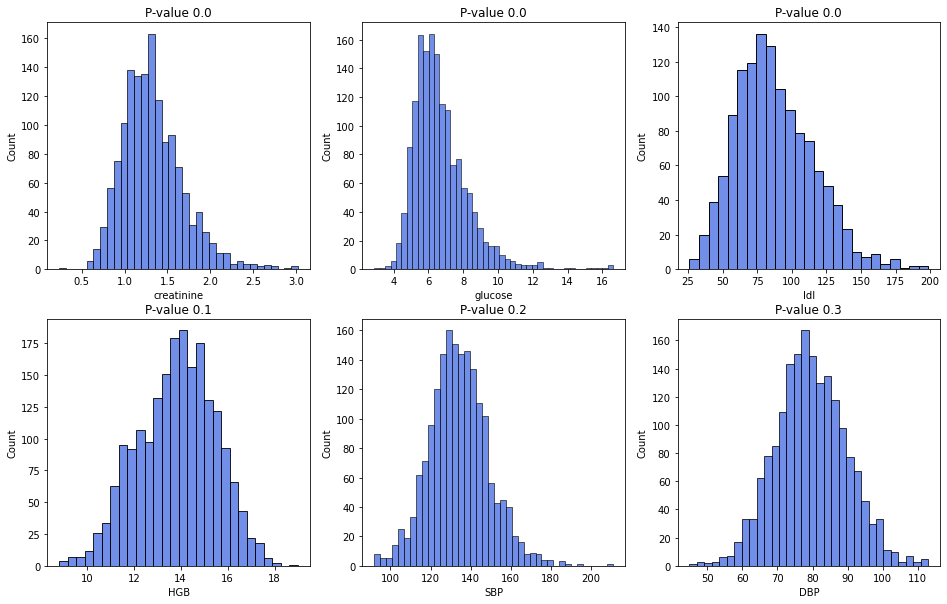

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for variable, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    p_val_KS = round(stats.kstest(biomarkers_df[variable].dropna(), 
                            stats.norm.rvs(loc = biomarkers_df[variable].dropna().mean(), 
                                           scale = biomarkers_df[variable].dropna().std(), 
                                           size=100000)).pvalue, 2)

    title = str('P-value ' + str(p_val_KS))
    sns.histplot(biomarkers_df[variable], ax=subplot, color = 'royalblue').set(title=title)

In [ ]:
'''

Bi-variate analysis

'''

Stage_Progress     False      True
gender                            
Female          0.750000  0.250000
Male            0.548387  0.451613
Stage_Progress  False  True
gender                     
Female            132    44
Male               68    56


<AxesSubplot:xlabel='gender'>

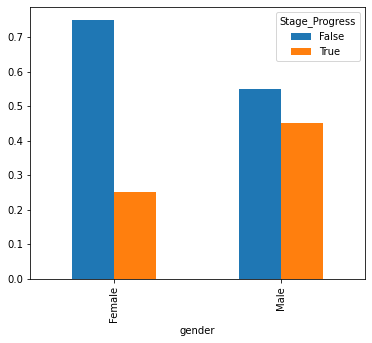

In [21]:
plt.rcParams['figure.figsize'] = [6, 5]
print(pd.crosstab(subj_df.gender, subj_df.Stage_Progress, normalize='index'))
print(pd.crosstab(subj_df.gender, subj_df.Stage_Progress))
pd.crosstab(subj_df.gender, subj_df.Stage_Progress, normalize='index').plot.bar()

Stage_Progress     False      True
race                              
Asian           0.705882  0.294118
Black           0.750000  0.250000
Hispanic        0.571429  0.428571
Unknown         0.615385  0.384615
White           0.663717  0.336283
Stage_Progress  False  True
race                       
Asian              12     5
Black              18     6
Hispanic            4     3
Unknown            16    10
White             150    76


<AxesSubplot:xlabel='race'>

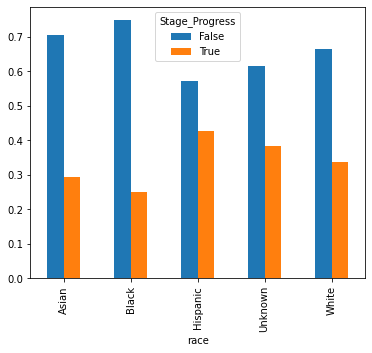

In [22]:
print(pd.crosstab(subj_df.race, subj_df.Stage_Progress, normalize='index'))
print(pd.crosstab(subj_df.race, subj_df.Stage_Progress))
pd.crosstab(subj_df.race, subj_df.Stage_Progress, normalize='index').plot.bar()

<AxesSubplot:xlabel='Stage_Progress', ylabel='age'>

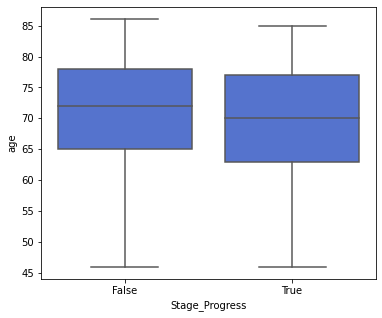

In [23]:
sns.boxplot(x='Stage_Progress', y='age', 
                data=subj_df, 
                color = 'royalblue')

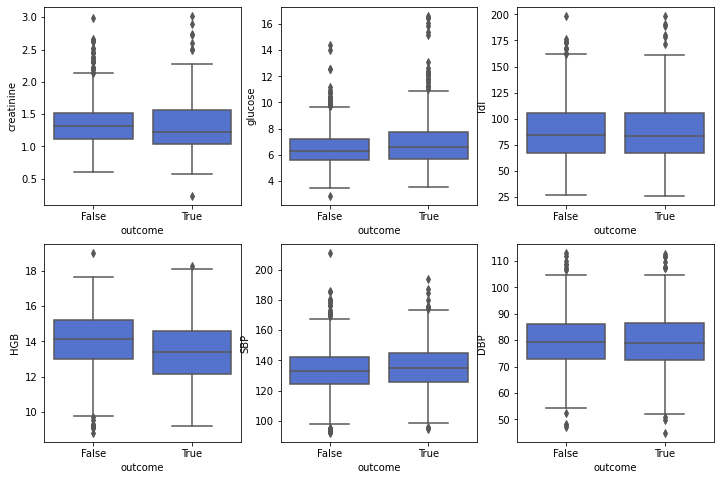

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for var, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    sns.boxplot(x='outcome', y=var, 
                data=biomarkers_df, 
                ax=subplot, 
                color = 'royalblue')

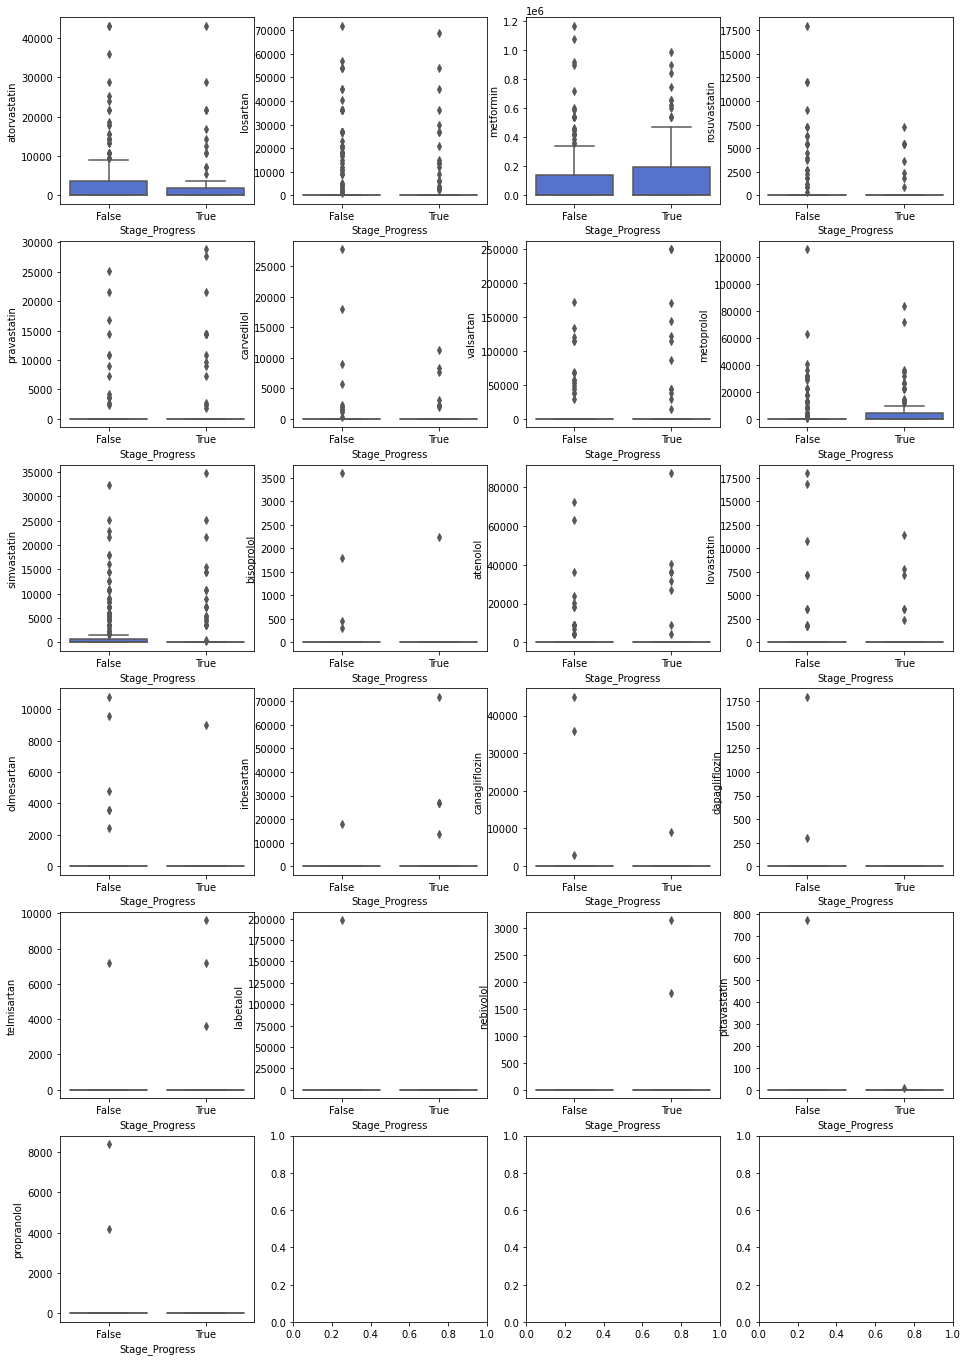

In [25]:
# boxplots medications ~ outcomne 

fig, ax = plt.subplots(6, 4, figsize=(16, 24))
for var, subplot in zip(subj_meds_df[list(meds_df.drug.unique())].columns, ax.flatten()):                                     
    sns.boxplot(x='Stage_Progress', y=var, 
                data=subj_meds_df, 
                ax=subplot, 
                color = 'royalblue')

In [26]:
# boxplots medications ~ outcomne 
pd.set_option('display.max_rows', 25)
meds_kruskal_df = pd.DataFrame(columns = ['drug', 'p_value'])
for var in subj_meds_df[list(meds_df.drug.unique())].columns:
    s1 = subj_meds_df[subj_meds_df.Stage_Progress == True][var]
    s2 = subj_meds_df[subj_meds_df.Stage_Progress == False][var]
    res = stats.kruskal(s1, s2)
    meds_kruskal_df.loc[len(meds_kruskal_df)] = [var ,res.pvalue]

meds_features = list(meds_kruskal_df[meds_kruskal_df.p_value < 0.05].drug) # medication features for prediction
meds_kruskal_df[meds_kruskal_df.p_value < 0.05].sort_values('p_value')

,drug,p_value
13,irbesartan,0.008572
4,pravastatin,0.015342
7,metoprolol,0.026337
18,nebivolol,0.045141


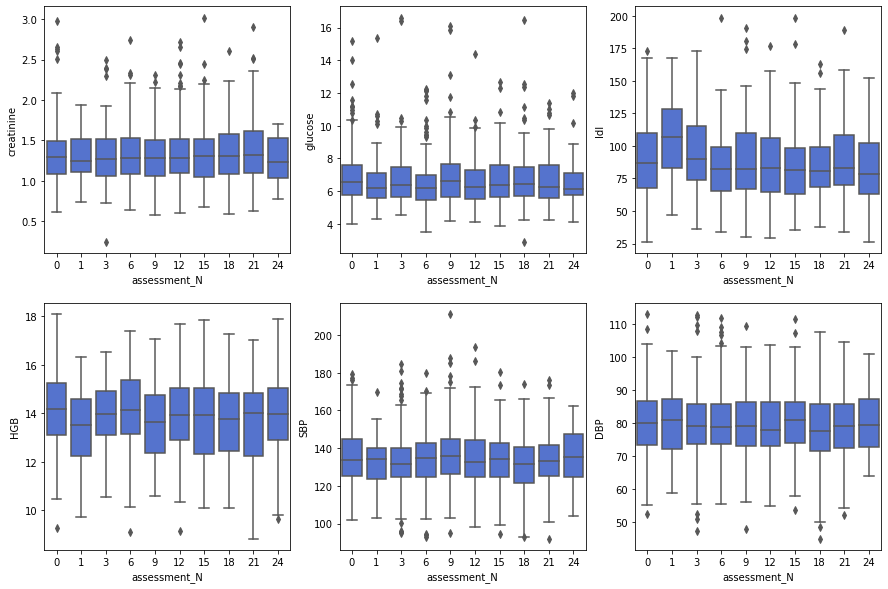

In [27]:
biomarkers_df['assessment_N'] = biomarkers_df.assessment.str.split('_', expand=True)[1]
dataset = biomarkers_df[biomarkers_df.time_day < 764]

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for var, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    sns.boxplot(x='assessment_N', y=var, 
                data=dataset, 
                ax=subplot, 
                color = 'royalblue',
                order=list(map(str, np.sort(dataset.assessment_N.astype(int).unique()))))

<AxesSubplot:xlabel='assessment_N', ylabel='HGB'>

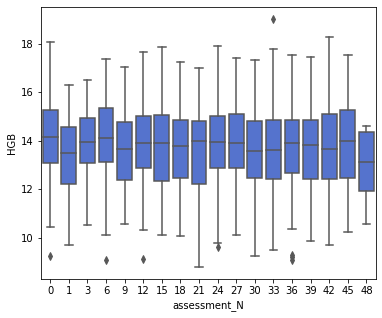

In [28]:
sns.boxplot(x='assessment_N', y='HGB', 
                data=biomarkers_df, 
                color = 'royalblue',
                order=list(map(str, np.sort(biomarkers_df.assessment_N.astype(int).unique()))))

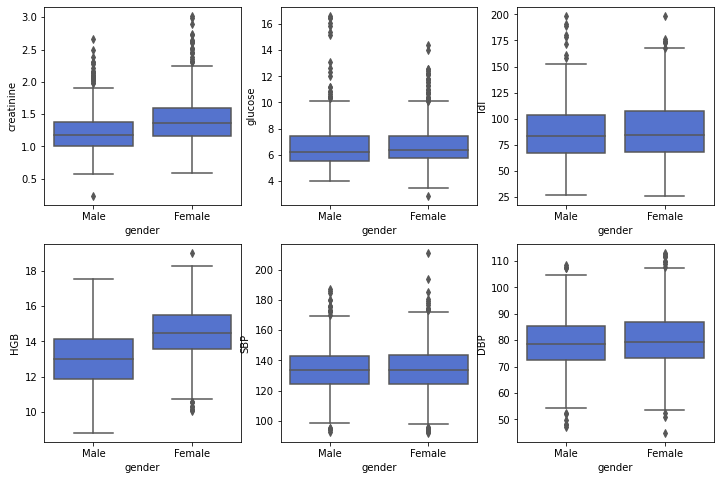

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for var, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    sns.boxplot(x='gender', y=var, 
                data=biomarkers_df, 
                ax=subplot, 
                color = 'royalblue')

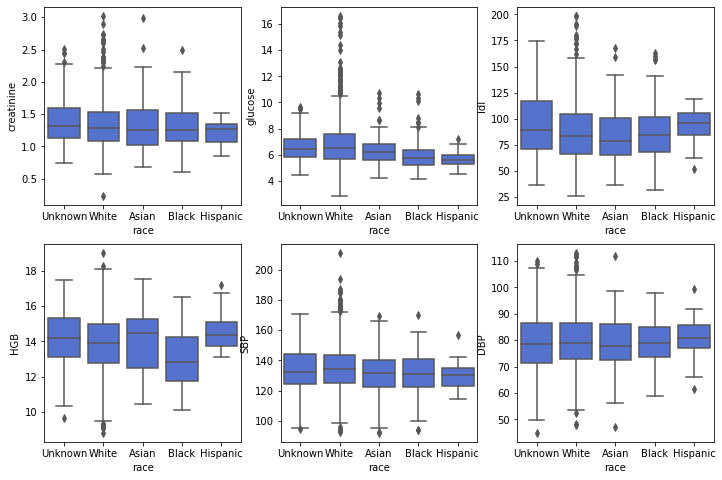

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for var, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    sns.boxplot(x='race', y=var, 
                data=biomarkers_df, 
                ax=subplot, 
                color = 'royalblue')

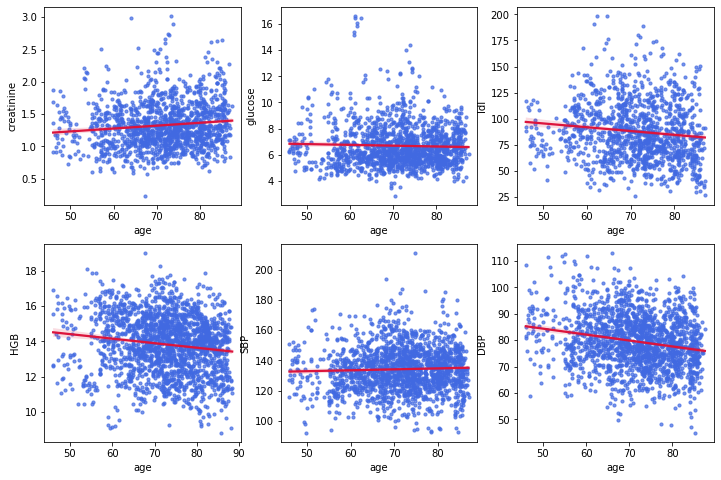

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for var, subplot in zip(biomarkers_df[['creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns, ax.flatten()):
    sns.regplot(x='age', y=var, 
                 data=biomarkers_df, 
                 ax=subplot, 
                 color = 'royalblue',
                 scatter_kws={"color": "royalblue", 'alpha': 0.7, 's': 10}, 
                 line_kws={"color": "crimson"})
    

In [392]:
'''

Repeated-measures within-subjects analysis of variance
+ between-subjects factors

'''

'\n\nRepeated-measures within-subjects analysis of variance\n+ between-subjects factors\n\n'

In [32]:
# aggregate values per assessments, remove NaNs...

biomarkers_df.groupby(['id','assessment']).creatinine.mean()

id   assessment 
S0   baseline_0     1.29
     followup_1      NaN
     followup_3     1.15
     followup_6      NaN
     followup_9     1.44
                    ... 
S99  followup_36     NaN
     followup_39     NaN
     followup_42     NaN
     followup_45     NaN
     followup_48     NaN
Name: creatinine, Length: 5400, dtype: float64

In [ ]:
'''

Evidence-based model approach

'''

In [33]:
GFR_cutoff = [0, 14, 29, 44, 59, 89, np.inf] # eGFR cutoff points
stages = ['G5', 'G4', 'G3b', 'G3a', 'G2', 'G1'] # stage 
CKD_stages_N = {'G5': 5, 'G4': 4, 'G3b': 3.5, 'G3a': 3, 'G2': 2, 'G1': 1}

def eGFR(data):
    #if np.isnan(creatinine) == True:
    #    pass
    K = 0.7 if data.gender == "Female" else 0.9
    a = -0.241 if data.gender == "Female" else -0.302
    k2 = 1.012 if data.gender == "Female" else 1
    result = 142 * min(data.creatinine/K, 1)**a * max(data.creatinine/K, 1)**-1.200 * 0.9938**data.age * k2
    return result

In [34]:
# 1. Compute observed eGFR using evidence-based equation

biomarkers_df['eGFR'] = biomarkers_df[['age', 'gender','creatinine']].apply(eGFR, axis = 1)
biomarkers_df['CKD_stage'] = pd.cut(biomarkers_df.eGFR, GFR_cutoff, labels = stages)
biomarkers_df.sort_values(['id', 'time_day'])

,id_time,id,time_day,creatinine,glucose,ldl,HGB,SBP,DBP,assessment,gender,race,age,outcome,assessment_N,eGFR,CKD_stage
id_time,,,,,,,,,,,,,,,,,
S0_0,S0_0,S0,0.0,1.29,6.24,161.49,13.51,134.11,95.32,baseline_0,Male,Unknown,70.000000,True,0,59.648726,G2
S0_98,S0_98,S0,98.0,NaN,NaN,NaN,NaN,133.75,83.98,followup_3,Male,Unknown,70.268493,True,3,NaN,NaN
S0_107,S0_107,S0,107.0,1.15,7.20,111.39,13.39,NaN,NaN,followup_3,Male,Unknown,70.293151,True,3,68.340730,G2
S0_279,S0_279,S0,279.0,NaN,NaN,NaN,NaN,125.08,65.97,followup_9,Male,Unknown,70.764384,True,9,NaN,NaN
S0_286,S0_286,S0,286.0,1.44,7.01,NaN,12.84,NaN,NaN,followup_9,Male,Unknown,70.783562,True,9,52.018452,G3a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S99_413,S99_413,S99,413.0,NaN,NaN,NaN,NaN,145.03,82.71,followup_15,Female,Black,74.131507,False,15,NaN,NaN
S99_496,S99_496,S99,496.0,1.26,5.94,NaN,NaN,NaN,NaN,followup_18,Female,Black,74.358904,False,18,44.699008,G3a
S99_500,S99_500,S99,500.0,NaN,NaN,162.60,NaN,NaN,NaN,followup_18,Female,Black,74.369863,False,18,NaN,NaN


LinregressResult(slope=-1.3468695639293555, intercept=54.45554178566985, rvalue=-0.04167210715165831, pvalue=0.11408196046509857, stderr=0.8518718667401249, intercept_stderr=0.8616386222204434)


<AxesSubplot:xlabel='time_day', ylabel='eGFR'>

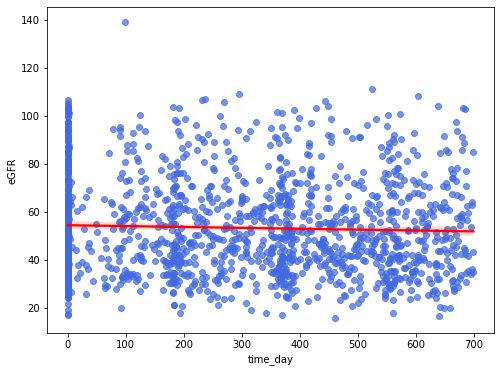

In [35]:
# 2. Plot and fit liner model: eGFR ~ time
dataset = biomarkers_df[biomarkers_df.eGFR.isna() == False]
plt.rcParams['figure.figsize'] = [8, 6]
print(stats.linregress(dataset.time_day/365, dataset.eGFR))
sns.regplot(x='time_day', y='eGFR', data = dataset, 
            scatter_kws={"color": "royalblue", 'alpha': 0.7}, line_kws={"color": "red"})

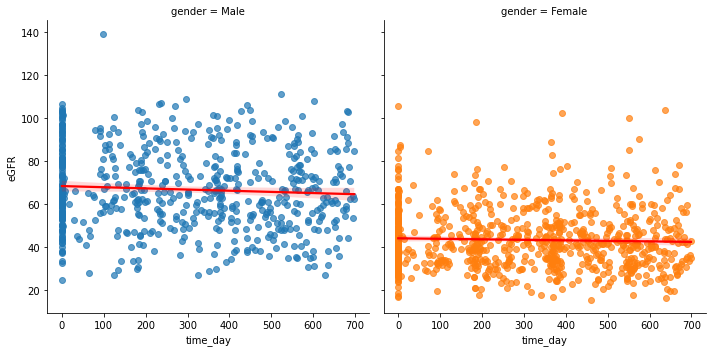

In [36]:
sns.lmplot(x="time_day", 
           y="eGFR", 
           hue="gender",
           col="gender",
           data=dataset,
           scatter_kws={'alpha': 0.7},
           line_kws={"color": "red"})

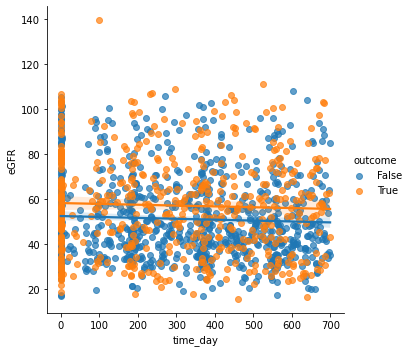

In [37]:
g = sns.lmplot(x="time_day", 
           y="eGFR", 
            hue="outcome",
           data=dataset,
          scatter_kws={'alpha': 0.7})

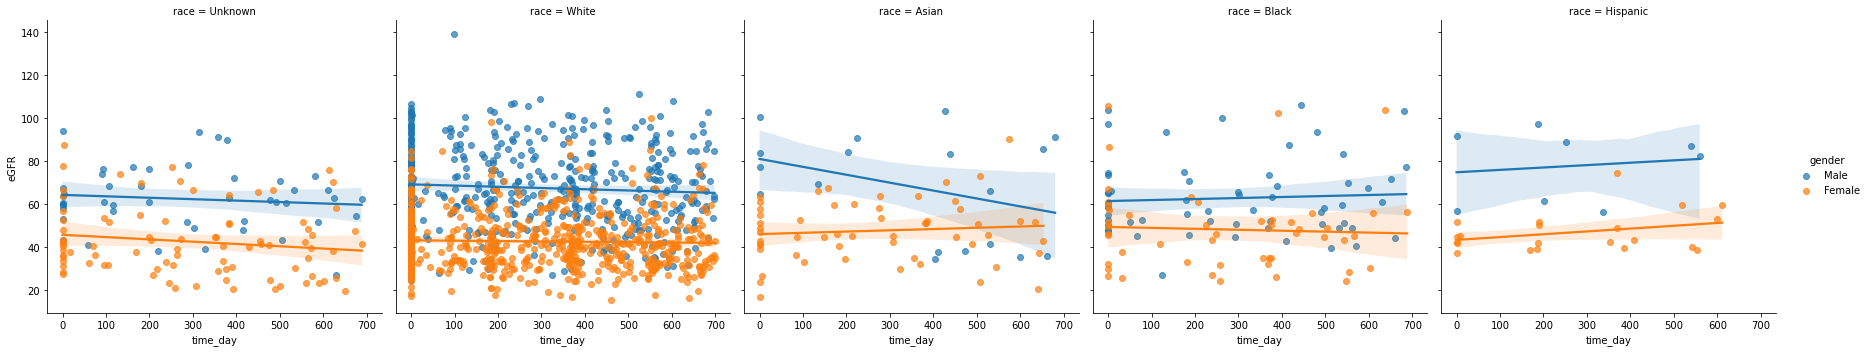

In [38]:
g = sns.lmplot(x="time_day", 
           y="eGFR", 
           col="race",
            hue="gender",
           data=dataset,
          scatter_kws={'alpha': 0.7})

In [ ]:
'''
Next:
3. Fit individual-level linear models of eGFR and other biomarkers
'''

In [39]:
# 3.2. Fit and plot individual-level linear models of biomarker time series
biomarker_lm_res = pd.DataFrame()
for var in biomarkers_df[['eGFR','creatinine', 'glucose', 'ldl', 'HGB', 'SBP', 'DBP']].columns:
    data_set = biomarkers_df[biomarkers_df[var].isna() == False]
    biomarker_lm = pd.DataFrame(columns = ['id', 'intercept', 'slope', 'pvalue', 'R2'])
    for sid in data_set.id.unique():
        sid_data_set = data_set[data_set.id == sid]
        indiv_lm = stats.linregress(sid_data_set.time_day/365, sid_data_set[var])
        biomarker_lm.loc[len(biomarker_lm)] = [sid, indiv_lm.intercept, indiv_lm.slope, indiv_lm.pvalue, indiv_lm.rvalue**2]
    biomarker_lm = biomarker_lm.set_index('id')
    new_names = [(i, var + '_' + i) for i in biomarker_lm.columns]
    biomarker_lm.rename(columns = dict(new_names), inplace=True)
    biomarker_lm_res = pd.concat([biomarker_lm_res, biomarker_lm], axis = 1)

In [40]:
biomarker_lm_res[biomarker_lm_res.eGFR_pvalue < 0.05]

,eGFR_intercept,eGFR_slope,eGFR_pvalue,eGFR_R2,creatinine_intercept,creatinine_slope,creatinine_pvalue,creatinine_R2,glucose_intercept,glucose_slope,...,HGB_pvalue,HGB_R2,SBP_intercept,SBP_slope,SBP_pvalue,SBP_R2,DBP_intercept,DBP_slope,DBP_pvalue,DBP_R2
id,,,,,,,,,,,,,,,,,,,,,
S106,70.809362,-22.990291,0.007331,0.791298,1.296262,0.539100,0.012482,0.743945,5.027204,0.213400,...,0.404526,0.058565,118.921448,14.313032,0.019322,0.697647,76.409767,4.849856,0.364579,0.165808
S125,36.481198,-2.796202,0.041464,0.797046,1.459685,0.101264,0.055467,0.756040,9.448800,-1.740423,...,0.542542,0.135242,124.738692,-2.767953,0.758027,0.020743,75.612218,0.444577,0.926406,0.001883
S128,94.622866,-21.053550,0.040476,0.800138,0.779277,0.287438,0.072165,0.712443,6.411568,0.498362,...,0.435699,0.318436,150.702895,-11.176740,0.056807,0.752353,91.490724,-4.390434,0.332941,0.306542
S132,102.031653,-21.964431,0.030698,0.640225,0.804062,0.262662,0.050980,0.566198,5.978783,0.321218,...,0.107451,0.262059,134.203675,-9.334453,0.004671,0.761713,75.887383,2.411179,0.531667,0.068355
S133,59.551454,922.904774,0.035990,0.996807,1.242857,-13.296429,0.021612,0.998848,6.007143,62.571429,...,0.607839,0.056480,125.419638,0.165485,0.966401,0.001129,74.605141,1.271290,0.670574,0.108522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S67,37.393826,1.847054,0.000000,1.000000,1.480000,-0.064538,0.000000,1.000000,8.199701,-0.447703,...,0.294363,0.266567,122.978341,-0.160066,0.982650,0.000104,69.120336,2.046146,0.651042,0.044169
S68,84.478388,-23.904626,0.019345,0.999077,0.837716,0.276389,0.029942,0.997789,9.581858,-3.171235,...,0.410738,0.232522,121.540486,1.220481,0.954086,0.002108,89.676786,-9.556820,0.107695,0.796209
S7,41.468735,-6.682727,0.000000,1.000000,1.430000,0.215915,0.000000,1.000000,5.497471,0.516672,...,0.937725,0.009538,140.822396,-5.946936,0.884131,0.032762,91.515546,-9.504558,0.373229,0.693909


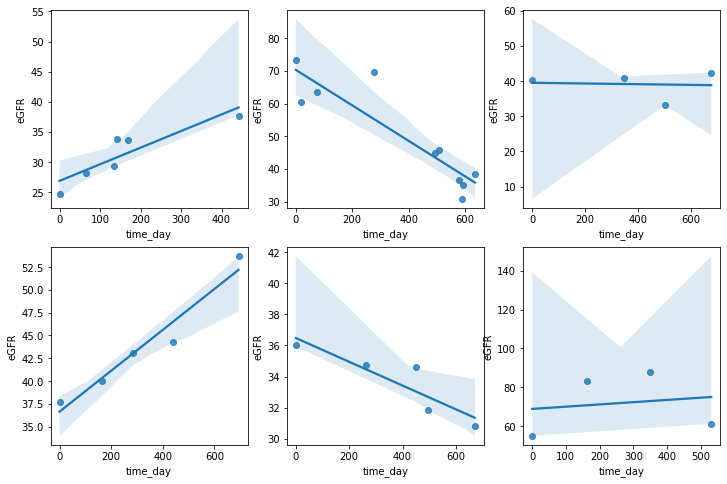

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for sid, subplot in dict(zip(['S293', 'S179', 'S98', 'S286', 'S125', 'S201'], ax.flatten())).items():
    data_set = dataset[dataset.id == sid]
    sns.regplot(x='time_day', y='eGFR', ax=subplot, data = data_set)

In [ ]:
'''
This approach maybe less preferable to Lmer if the number of observations per group are few, 
but the number of groups is large, and estimates are much noisier and are not smoothed/regularized as in 
multilevel mixed effects model (lmer).
'''

In [42]:
# 4. Fit and plot mixed effect (multilevel) liner model
# use Pymer4

from pymer4.models import Lmer

In [112]:
model1 = Lmer("eGFR ~ time_day + (1 + time_day | id)", data=dataset)
model1.fit(control='optimizer="bobyqa", optCtrl=list(maxfun=2e4)')

[1] "Model failed to converge with max|grad| = 0.064742 (tol = 0.002, component 1)"
[2] " \n"                                                                          

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

Formula: eGFR~time_day+(1+time_day|id)

Family: gaussian	 Inference: parametric

Number of observations: 1439	 Groups: {'id': 300.0}

Log-likelihood: -5704.200 	 AIC: 11408.401

Random effects:

                 Name      Var     Std
id        (Intercept)  331.445  18.206
id           time_day    0.000   0.014
Residual                80.619   8.979

            IV1       IV2   Corr
id  (Intercept)  time_day -0.289

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),54.802,52.596,57.009,1.126,298.340,48.686,0.000,***
time_day,-0.004,-0.006,-0.001,0.001,280.431,-2.641,0.009,**


In [109]:
model1.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),54.802444,52.596267,57.008620,1.125621,298.339655,48.686411,5.511836e-144,***
time_day,-0.003633,-0.006329,-0.000937,0.001376,280.431054,-2.640697,8.737334e-03,**


In [110]:
# get effects (intercept and slope) for each subject from MELM

pd.set_option('display.max_rows', None)
model_coef = model1.fixef
model_coef.time_day = model_coef.time_day * 365
model_coef.rename(columns = {"(Intercept)": 'eGFR_intercept_RE', 'time_day': 'eGFR_slope_RE'}, inplace = True) # rename column biomarker variable

<AxesSubplot:xlabel='time_day', ylabel='eGFR'>

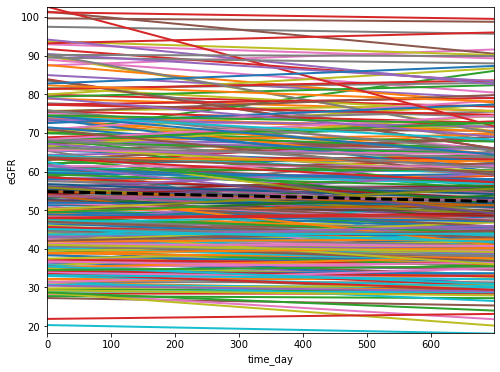

In [113]:
model1.plot("time_day", plot_ci=True, ylabel="eGFR")

In [53]:
# aggregate values per subjects 

biomarkers_summay = biomarkers_df.groupby('id').agg({'creatinine': ['mean','std', 'last'],
                                                    'glucose': ['mean','std','last'], 
                                                    'HGB': ['mean','std','last'],
                                                    'ldl': ['mean','std','last'],
                                                    'SBP': ['mean','std','last'],
                                                    'DBP': ['mean','std','last'],
                                                    'eGFR': 'last',
                                                    'CKD_stage': 'last'})

biomarkers_summay.columns = ['_'.join(col).strip() for col in biomarkers_summay.columns.values]

In [ ]:
'''
GENERAL MODEL:

Stage_progression = eGFR intercept + eGRF last value + individual eGFR regression slope + eGFR p-value + eGFR R2
                    + biomarker linear estimates [intercept, slope, p-value, R2] 
                        {creatinine + glucose + HGB + SBP + DBP + LDL}
                    + biomarkers [last value and mean] 
                        {creatinine + glucose + HGB + SBP + DBP + LDL}
                    + health risk factors [categorical binary]
                        {Diabetes  + Anemia + Hypertension  + Dyslipidemia + Medications}
                    + demographics 
                        {age, gender}
                        
                        
                        
VARIATION OPTIONS:

1. Logistic regression is used to fit model and estimate goodness-of-fit (pseudo R2 and confusion matrix)
Repeated measures (time-series domain) is transformed into scalar estimates obtained via 
fitting mixed-effect (milti-level) linear models and/or  subject-sample-only linear model
    1.1. Only eGFR is fitted and estimated: intercept, last value and slope are extracted and used as features
        1.1.1. Other biomarkers are averaged (+std) and last measurement taken as features
        1.1.2. Other biomarkers are averaged and last measurement taken and then transformed into binary categorical (+std)
    1.2. All repeated measures data (bioamrkers) are estimated: intercepts, last values and slopes are extracted 
        1.2.1. Used alone as predictirs
        ? 1.2.2. Used with categorical dummy 

2. Mixed-effect (repated measures) logistic regression is used to fit the model
    2.1. Repeated measures (time-series domain) -> aggregated into regular assessment intervals
    

'''

In [104]:
pd.set_option('display.max_rows', 10)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [63]:
# prepare data set
study_df_3 = pd.concat([subj_meds_df, model_coef, biomarker_lm_res, biomarkers_summay], axis = 1)

In [124]:
biomarkers_kruskal_df

,drug,p_value
0,eGFR_intercept,0.011132
1,eGFR_slope,0.352886
2,eGFR_pvalue,0.316140
3,eGFR_R2,0.400876
4,creatinine_intercept,0.220920
...,...,...
36,glucose_std,0.300059
37,HGB_std,0.190603
38,ldl_std,0.403255
39,SBP_std,0.353618


In [126]:
# biomarkers feature selection

pd.set_option('display.max_rows', 25)
biomarkers_kruskal_df = pd.DataFrame(columns = ['biomarker', 'p_value'])
for var in ['eGFR_intercept', 'eGFR_slope', 'eGFR_pvalue', 'eGFR_R2',
            'creatinine_intercept','creatinine_slope', 'creatinine_pvalue', 'creatinine_R2',
            'glucose_intercept', 'glucose_slope', 'glucose_pvalue', 'glucose_R2',
            'ldl_intercept', 'ldl_slope', 'ldl_pvalue', 'ldl_R2', 
            'HGB_intercept','HGB_slope', 'HGB_pvalue', 'HGB_R2', 
            'SBP_intercept', 'SBP_slope',  'SBP_pvalue', 'SBP_R2', 
            'DBP_intercept', 'DBP_slope', 'DBP_pvalue', 'DBP_R2',
           'eGFR_last','creatinine_last', 'glucose_last', 'HGB_last', 'ldl_last', 'SBP_last', 'DBP_last', 
           'creatinine_std', 'glucose_std', 'HGB_std', 'ldl_std', 'SBP_std', 'DBP_std', ]:
    s1 = study_df_3[study_df_3.Stage_Progress == True][var]
    s2 = study_df_3[study_df_3.Stage_Progress == False][var]
    res = stats.kruskal(s1, s2)
    biomarkers_kruskal_df.loc[len(biomarkers_kruskal_df)] = [var ,res.pvalue]

biomarkers_features = list(biomarkers_kruskal_df[biomarkers_kruskal_df.p_value < 0.05].biomarker) # medication features for prediction
biomarkers_kruskal_df[biomarkers_kruskal_df.p_value < 0.05].sort_values('p_value')

,biomarker,p_value
13,ldl_slope,1.155435e-17
21,SBP_slope,2.886544e-07
9,glucose_slope,2.864220e-06
30,glucose_last,2.344582e-04
33,SBP_last,2.728667e-04
25,DBP_slope,5.143273e-04
28,eGFR_last,5.564403e-04
16,HGB_intercept,8.535493e-04
31,HGB_last,2.629599e-03
32,ldl_last,2.851901e-03


In [64]:
# compute additional features: risk health conditions by clinical criteria
# merge feature datasets

study_df_3['Hypertension_last'] = study_df_3[['DBP_last', 'SBP_last']].apply(lambda x: 1 if ((x.SBP_last > 135) | (x.DBP_last > 85)) else 0, axis = 1)
study_df_3['Hypertension_mean'] = study_df_3[['DBP_mean', 'SBP_mean']].apply(lambda x: 1 if ((x.SBP_mean > 135) | (x.DBP_mean > 85)) else 0, axis = 1)

study_df_3['T2D_last'] = study_df_3['glucose_last'].apply(lambda x: 1 if x > 7 else 0)
study_df_3['T2D_mean'] = study_df_3['glucose_mean'].apply(lambda x: 1 if x > 7 else 0)

study_df_3['highCreatinine_last'] = study_df_3['creatinine_last'].apply(lambda x: 1 if x > 1.5 else 0)
study_df_3['highCreatinine_mean'] = study_df_3['creatinine_mean'].apply(lambda x: 1 if x > 1.5 else 0)

study_df_3['Dislipidemia_last'] = study_df_3['ldl_last'].apply(lambda x: 1 if x > 130 else 0)
study_df_3['Dislipidemia_mean'] = study_df_3['ldl_mean'].apply(lambda x: 1 if x > 130 else 0)

study_df_3['Anemia_last'] = study_df_3[['HGB_last','gender']].apply(lambda x: 1 if ((x.gender == 'Male') & (x.HGB_last < 13.5)) | ((x.gender == 'Female') & (x.HGB_last < 12)) else 0, axis = 1)
study_df_3['Anemia_mean'] = study_df_3[['HGB_mean','gender']].apply(lambda x: 1 if ((x.gender == 'Male') & (x.HGB_mean < 13.5)) | ((x.gender == 'Female') & (x.HGB_mean < 12)) else 0, axis = 1)

study_df_3['CKD_stage_N_last'] = study_df_3.CKD_stage_last.map(CKD_stages_N)
study_df_3.gender = study_df_3.gender.apply(lambda x: 1 if x == "Male" else 0)
study_df_3.to_csv('study_df_3.csv')

In [127]:
Y = study_df_3[['Stage_Progress']].apply(int, axis = 1)
x_train_1 = study_df_3[biomarkers_features + meds_features]

In [128]:
# building the model and fitting the data
log_reg = sm.Logit(Y, x_train_1).fit()
print(log_reg.summary())

         Current function value: 0.377181
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  300
Model:                          Logit   Df Residuals:                      281
Method:                           MLE   Df Model:                           18
Date:                Wed, 23 Feb 2022   Pseudo R-squ.:                  0.4074
Time:                        06:28:19   Log-Likelihood:                -113.15
converged:                      False   LL-Null:                       -190.95
Covariance Type:            nonrobust   LLR p-value:                 6.035e-24
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
eGFR_intercept      0.0052      0.013      0.413      0.679      -0.020       0.030
glucose_slope      -0.0273      0.042     -0.647  

/Users/yurir/opt/anaconda3/envs/kernel2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
''' 

Using biomarker regression coefficines as features in prediction modelling

''' 

In [68]:
Y = study_df_3[['Stage_Progress']].apply(int, axis = 1)

X1 = study_df_3[['gender', 'age', 
                'eGFR_intercept', 'eGFR_slope', 'eGFR_pvalue', 'eGFR_R2',
                'creatinine_intercept','creatinine_slope', 'creatinine_pvalue', 'creatinine_R2',
                'glucose_intercept', 'glucose_slope', 'glucose_pvalue', 'glucose_R2',
                'ldl_intercept', 'ldl_slope', 'ldl_pvalue', 'ldl_R2', 
                'HGB_intercept','HGB_slope', 'HGB_pvalue', 'HGB_R2', 
                'SBP_intercept', 'SBP_slope',  'SBP_pvalue', 'SBP_R2', 
                'DBP_intercept', 'DBP_slope', 'DBP_pvalue', 'DBP_R2'] + meds_features]

X2 = study_df_3[['gender', 'age', 
                'eGFR_intercept', 'eGFR_slope', 'eGFR_pvalue', 'eGFR_R2',
                'creatinine_intercept','creatinine_slope', 'creatinine_pvalue', 'creatinine_R2',
                'glucose_intercept', 'glucose_slope', 'glucose_pvalue', 'glucose_R2',
                'ldl_intercept', 'ldl_slope', 'ldl_pvalue', 'ldl_R2', 
                'HGB_intercept','HGB_slope', 'HGB_pvalue', 'HGB_R2', 
                'SBP_intercept', 'SBP_slope',  'SBP_pvalue', 'SBP_R2', 
                'DBP_intercept', 'DBP_slope', 'DBP_pvalue', 'DBP_R2', 
                'eGFR_last','creatinine_last', 'glucose_last', 'HGB_last', 'ldl_last', 'SBP_last', 'DBP_last', 
                 'Hypertension_last',  'T2D_last', 'highCreatinine_last', 
                 'Dislipidemia_last', 'Anemia_last', 'CKD_stage_N_last'] + meds_features]

X3 = study_df_3[['gender', 'age', 
                 'eGFR_slope', 'eGFR_pvalue', 'eGFR_R2',
                 'creatinine_slope', 'creatinine_pvalue', 'creatinine_R2',
                 'glucose_slope', 'glucose_pvalue', 'glucose_R2',
                 'ldl_slope', 'ldl_pvalue', 'ldl_R2', 
                 'HGB_slope', 'HGB_pvalue', 'HGB_R2', 
                 'SBP_slope',  'SBP_pvalue', 'SBP_R2', 
                 'DBP_slope', 'DBP_pvalue', 'DBP_R2', 
                 'eGFR_last','creatinine_last', 'glucose_last', 'HGB_last', 'ldl_last', 'SBP_last', 'DBP_last', 
                 'Hypertension_last',  'T2D_last', 'highCreatinine_last', 
                 'Dislipidemia_last', 'Anemia_last', 'CKD_stage_N_last'] + meds_features]


In [69]:
# building the model and fitting the data
log_reg = sm.Logit(Y, X2).fit()
print(log_reg.summary())

         Current function value: 0.320122
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  300
Model:                          Logit   Df Residuals:                      253
Method:                           MLE   Df Model:                           46
Date:                Wed, 23 Feb 2022   Pseudo R-squ.:                  0.4971
Time:                        04:32:39   Log-Likelihood:                -96.037
converged:                      False   LL-Null:                       -190.95
Covariance Type:            nonrobust   LLR p-value:                 2.195e-19
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
gender                  -0.9082      0.783     -1.160      0.246      -2.443       0.626
age                     -0.0329    

/Users/yurir/opt/anaconda3/envs/kernel2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Confusion matrix 
 [[185  15]
 [ 30  70]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.82      0.70      0.76       100

    accuracy                           0.85       300
   macro avg       0.84      0.81      0.82       300
weighted avg       0.85      0.85      0.85       300



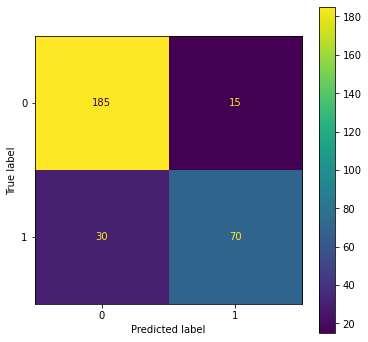

In [129]:
# train logistic regression model (No data splits)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(x_train_1, Y)
y_pred = logreg.predict(x_train_1)

# performance evaluation: confusion matrix
CM = confusion_matrix(Y, y_pred)
print('Confusion matrix', '\n', CM)
print(metrics.classification_report(Y, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=CM)
disp.plot()
plt.show()

Confusion matrix 
 [[185  15]
 [ 31  69]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.82      0.69      0.75       100

    accuracy                           0.85       300
   macro avg       0.84      0.81      0.82       300
weighted avg       0.84      0.85      0.84       300



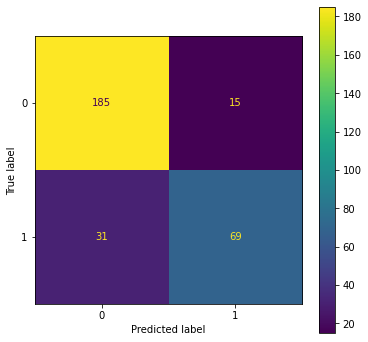

In [132]:
# train logistic regression model (No data splits)

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X2, Y)
y_pred = logreg.predict(X2)

# performance evaluation: confusion matrix
CM = confusion_matrix(Y, y_pred)
print('Confusion matrix', '\n', CM)
print(metrics.classification_report(Y, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=CM)
disp.plot()
plt.show()

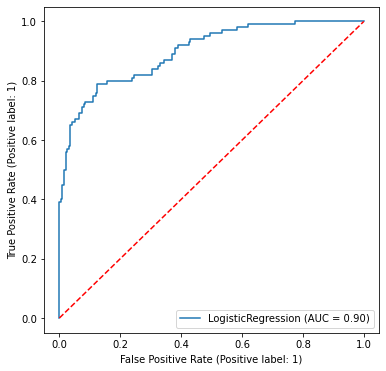

In [133]:
plt.rcParams['figure.figsize'] = [6, 6]
metrics.RocCurveDisplay.from_estimator(logreg, X2, Y, drop_intermediate=False)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

In [ ]:
# k-fold cross-validation

In [89]:
# prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=4, n_repeats=5, random_state=1)
log_model = LogisticRegression(solver='lbfgs', max_iter=5000)
scores_f1 = cross_val_score(log_model, X2, Y, scoring='f1_macro', cv=cv, n_jobs=-1)
scores_recall = cross_val_score(log_model, X2, Y, scoring='recall', cv=cv, n_jobs=-1) # alr performance metrics
scores_auc = cross_val_score(log_model, X2, Y, scoring='roc_auc', cv=cv, n_jobs=-1) # alr performance metrics

# report performance
print('F1_macro: %.3f (%.3f)' % (np.mean(scores_f1), np.std(scores_f1)))
print('Recall/Sensitivity: %.3f (%.3f)' % (np.mean(scores_recall), np.std(scores_recall)))
print('ROC_AUC: %.3f (%.3f)' % (np.mean(scores_auc), np.std(scores_auc)))

F1_macro: 0.762 (0.043)
Recall/Sensitivity: 0.637 (0.074)
ROC_AUC: 0.834 (0.042)
